# Student Performance from Game Play Using TensorFlow Decision Forests

---

This notebook will take you through the steps needed to train a baseline Gradient Boosted Trees Model using TensorFlow Decision Forests on the `Student Performance from Game Play` dataset made available for this competition, to predict if players will answer questions correctly.
We will load the data from a CSV file. Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd
  
dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.GradientBoostedTreesModel()
model.fit(tf_dataset)
  
print(model.summary())
```

We will also learn how to optimize reading of big datasets, do some feature engineering, data visualization and calculate better results using the F1-score


Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

One of the key aspects of TensorFlow Decision Forests that makes it even more suitable for this competition, particularly given the runtime limitations, is that it has been extensively tested for training and inference on CPUs, making it possible to train it on lower-end machines.

# Import the Required Libraries

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2023-04-21 09:52:21.136402: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 09:52:21.926969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/thor/miniconda3/envs/kaggle_py39/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
print("TensorFlow Decision Forests v" + tfdf.__version__)
print("TensorFlow Addons v" + tfa.__version__)
print("TensorFlow v" + tf.__version__)

TensorFlow Decision Forests v1.3.0
TensorFlow Addons v0.20.0
TensorFlow v2.12.0


# Load the Dataset

Since the dataset is huge, some people may face memory errors while reading the dataset from the csv. To avoid this, we will try to optimize the memory used by Pandas to load and store the dataset.


When Pandas loads a dataset, by default, it automatically detects the data types of the different columns.
Irresepective of the maximum value that is stored in these columns, Pandas assigns `int64` for numerical columns, `float64` for float columns, `object` dtype for string columns etc.


We may be able to reduce the size of these columns in memory by downcasting numerical columns to smaller types (like `int8`, `int32`, `float32` etc.), if their maximum values don't need the larger types for storage, (like `int64`, `float64` etc.).


Similarly, Pandas automatically detects string columns as `object` datatype. To reduce memory usage of string columns which store categorical data, we specify their datatype as `category`.


Many of the columns in this dataset can be downcast to smaller types.

We will provide a dict of `dtypes` for columns to pandas while reading the dataset.

In [85]:
# Reference: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/384359
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}
work_dir = 'data/predict-student-performance-from-game-play/'

train_df = pd.read_csv(work_dir+'train.csv', dtype=dtypes)
print("Full train dataset shape is {}".format(train_df.shape))

Full train dataset shape is (26296946, 20)


The data is composed of 20 columns and 26296946 entries. We can see all 20 dimensions of our dataset by printing out the first 5 entries using the following code:

In [8]:
# Display the first 5 examples
train_df.head(5)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


Please note that `session_id` uniquely identifies a user session.

# Load the labels

The labels for the training dataset are stored in the `train_labels.csv`. It consists of the information on whether the user in a particular session answered each question correctly. Load the labels data by running the following code. `

In [9]:
work_dir = 'data/predict-student-performance-from-game-play/'
labels = pd.read_csv(work_dir + 'train_labels.csv')

Each value in the column, `session_id` is a combination of both the session and the question number. 
We will split these into individual columns for ease of use.

In [10]:
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

 Let us take a look at the first 5 entries of `labels` using the following code:

In [11]:
# Display the first 5 examples
labels.head(5)

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


Our goal is to train models for each question to predict the label `correct` for any input user session. 

# Bar chart for label column: correct

First we will plot a bar chart for the values of the label `correct`.

<Axes: xlabel='correct'>

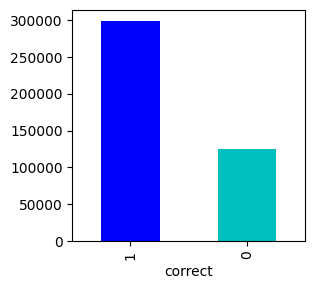

In [12]:
plt.figure(figsize=(3, 3))
plot_df = labels.correct.value_counts()
plot_df.plot(kind="bar", color=['b', 'c'])

Now, let us plot the values of the label column `correct` for each question.

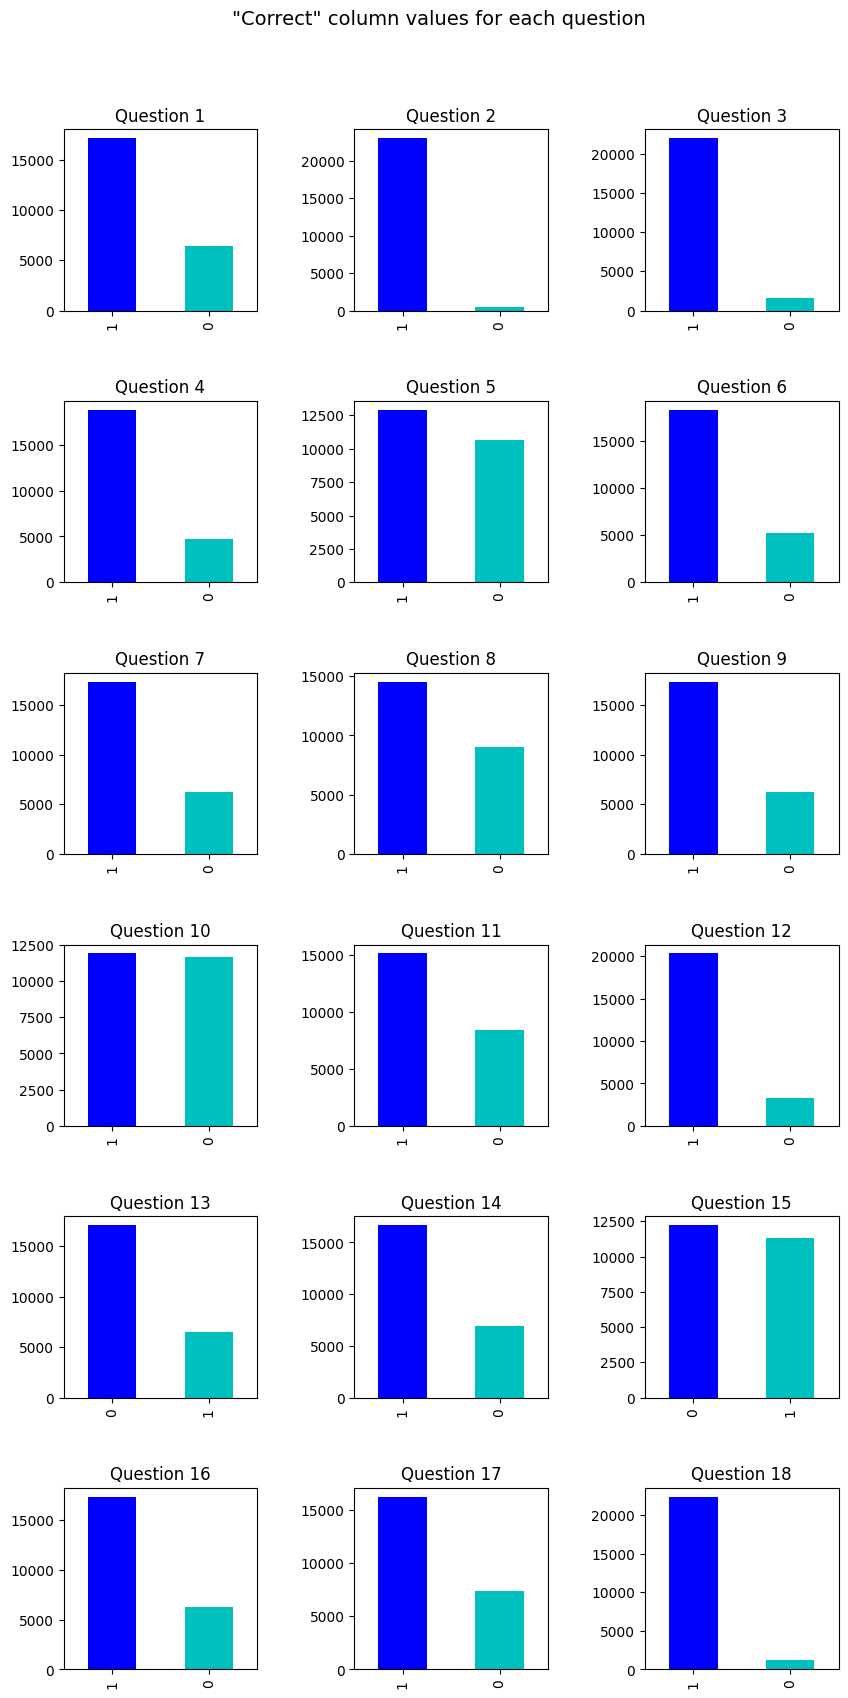

In [13]:
plt.figure(figsize=(10, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("\"Correct\" column values for each question", fontsize=14, y=0.94)
for n in range(1,19):
    #print(n, str(n))
    ax = plt.subplot(6, 3, n)

    # filter df and plot ticker on the new subplot axis
    plot_df = labels.loc[labels.q == n]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(ax=ax, kind="bar", color=['b', 'c'])
    
    # chart formatting
    ax.set_title("Question " + str(n))
    ax.set_xlabel("")


"""
question 1: accuracy 0.7371
question 2: accuracy 0.9752
question 3: accuracy 0.9349
question 4: accuracy 0.7957
question 5: accuracy 0.6391
question 6: accuracy 0.7921
question 7: accuracy 0.7431
question 8: accuracy 0.6325
question 9: accuracy 0.7700
question 10: accuracy 0.6092
question 11: accuracy 0.6616
question 12: accuracy 0.8691
question 13: accuracy 0.7240
question 14: accuracy 0.7384
question 15: accuracy 0.6276
question 16: accuracy 0.7488
question 17: accuracy 0.7019
question 18: accuracy 0.9510


{1: {'accuracy': 0.6204116344451904, 'f1_score': 0.7044439911842346},
 2: {'accuracy': 0.7791215777397156, 'f1_score': 0.8742600679397583},
 3: {'accuracy': 0.6917037963867188, 'f1_score': 0.8104369640350342},
 4: {'accuracy': 0.6830044388771057, 'f1_score': 0.7777446508407593},
 5: {'accuracy': 0.6384468674659729, 'f1_score': 0.6804200410842896},
 6: {'accuracy': 0.679821789264679, 'f1_score': 0.7772035598754883},
 7: {'accuracy': 0.6479949355125427, 'f1_score': 0.74629145860672},
 8: {'accuracy': 0.5601527690887451, 'f1_score': 0.6120156645774841},
 9: {'accuracy': 0.6509653925895691, 'f1_score': 0.7464939951896667},
 10: {'accuracy': 0.611075758934021, 'f1_score': 0.6343506574630737},
 11: {'accuracy': 0.6303840279579163, 'f1_score': 0.7115893363952637},
 12: {'accuracy': 0.6535115838050842, 'f1_score': 0.7734146118164062},
 13: {'accuracy': 0.6329302191734314, 'f1_score': 0.4757574796676636},
 14: {'accuracy': 0.6479949355125427, 'f1_score': 0.7374584078788757},
 15: {'accuracy': 0.6212603449821472, 'f1_score': 0.6380044221878052},
 16: {'accuracy': 0.5690643191337585, 'f1_score': 0.6749879717826843},
 17: {'accuracy': 0.5497559905052185, 'f1_score': 0.6241586804389954},
 18: {'accuracy': 0.7602376341819763, 'f1_score': 0.860390305519104}}
"""

# Prepare the dataset

As summarized in the competition overview, the dataset presents the questions and data to us in order of `levels - level segments`(represented by column `level_group`) 0-4, 5-12, and 13-22. We have to predict the correctness of each segment's questions as they are presented. To do this we will create basic aggregate features from the relevant columns. You can create more features to boost your scores. 

First, we will create two separate lists with names of the Categorical columns and Numerical columns. We will avoid columns `fullscreen`, `hq` and `music` since they don't add any useful value for this problem statement.

In [86]:
#create dummies
just_dummies = pd.get_dummies(train_df['event_name'])

train_df = pd.concat([train_df, just_dummies], axis=1)

train_df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,cutscene_click,map_click,map_hover,navigate_click,notebook_click,notification_click,object_click,object_hover,observation_click,person_click
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,...,True,False,False,False,False,False,False,False,False,False
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,...,False,False,False,False,False,False,False,False,False,True
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,...,False,False,False,False,False,False,False,False,False,True
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,...,False,False,False,False,False,False,False,False,False,True
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,...,False,False,False,False,False,False,False,False,False,True


In [83]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['navigate_click','person_click','cutscene_click','object_click','map_hover','notification_click',
            'map_click','observation_click','checkpoint','elapsed_time']

In [43]:


# count_var = ['event_name', 'fqid','room_fqid', 'text']
# mean_var = ['elapsed_time','level']
# event_var = ['navigate_click','person_click','cutscene_click','object_click','map_hover','notification_click',
#             'map_click','observation_click','checkpoint','elapsed_time']

# CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
# NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
#         'screen_coor_x', 'screen_coor_y', 'hover_duration']



For each categorical column, we will first group the dataset by `session_id`  and `level_group`. We will then count the number of **distinct elements** in the column for each group and store it temporarily.

For all numerical columns, we will group the dataset by `session id` and `level_group`. Instead of counting the number of distinct elements, we will calculate the `mean` and `standard deviation` of the numerical column for each group and store it temporarily.

After this, we will concatenate the temporary data frames we generated in the earlier step for each column to create our new feature engineered dataset.

In [28]:
# # reference: https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook
# def feature_engineer(train):
#     dfs = []
#     for c in count_var:
#         tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
#         tmp.name = tmp.name + '_nunique'
#         dfs.append(tmp)
#     for c in mean_var:
#         tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
#         dfs.append(tmp)
#     for c in event_var:
#         tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
#         tmp.name = tmp.name + '_sum'
#         dfs.append(tmp)
#     df = pd.concat(dfs,axis=1)
#     df = df.fillna(-1)
#     df = df.reset_index()
#     df = df.set_index('session_id')
#     return df

In [87]:
# Reference: https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook

def feature_engineer(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    # for c in NUMERICAL:
    #     tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('sum')
    #     tmp.name = tmp.name + '_sum'
    #     dfs.append(tmp)
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

In [88]:
dataset_df = feature_engineer(train_df)
print("Full prepared dataset shape is {}".format(dataset_df.shape))

Full prepared dataset shape is (70686, 26)


Our feature engineered dataset is composed of 22 columns and 70686 entries. 

# Basic exploration of the prepared dataset

Let us print out the first 5 entries using the following code:

In [89]:
# Display the first 5 examples
dataset_df.head(5)

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,navigate_click,person_click,cutscene_click,object_click,...,navigate_click_std,person_click_std,cutscene_click_std,object_click_std,map_hover_std,notification_click_std,map_click_std,observation_click_std,checkpoint_std,elapsed_time_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,0.490909,0.133333,0.169697,0.066667,...,0.501439,0.340969,0.376509,0.250203,0.154269,0.215442,0.109760,0.154269,0.077850,49246.539458
20090312431273200,13-22,10,3,49,12,35,0.404762,0.292857,0.142857,0.047619,...,0.491431,0.455616,0.350344,0.213213,0.179720,0.152637,0.118808,0.084313,0.048795,126666.129584
20090312431273200,5-12,10,3,39,11,24,0.347973,0.351351,0.040541,0.094595,...,0.477134,0.478201,0.197557,0.293150,0.171991,0.171991,0.162437,0.058124,0.058124,80175.676658
20090312433251036,0-4,11,4,22,6,11,0.352518,0.129496,0.258993,0.107914,...,0.479482,0.336963,0.439666,0.311393,0.145842,0.186892,0.145842,0.119517,0.084819,67372.714092
20090312433251036,13-22,11,6,73,16,43,0.491133,0.111796,0.050116,0.063994,...,0.500114,0.315237,0.218268,0.244836,0.350623,0.103372,0.183078,0.061993,0.027767,777382.529186


In [90]:
dataset_df.describe()

,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,navigate_click,person_click,cutscene_click,object_click,map_hover,...,navigate_click_std,person_click_std,cutscene_click_std,object_click_std,map_hover_std,notification_click_std,map_click_std,observation_click_std,checkpoint_std,elapsed_time_std
count,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,...,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04
mean,10.390021,3.885324,40.468650,10.268908,23.838412,0.410586,0.226448,0.123754,0.086291,0.029592,...,0.482838,0.403167,0.305849,0.268159,0.150879,0.169435,0.133771,0.083180,0.058552,9.322398e+05
std,0.832923,0.799293,13.020929,2.928351,8.989095,0.096683,0.096152,0.077015,0.054454,0.022882,...,0.019758,0.062836,0.097076,0.065254,0.074231,0.041417,0.023170,0.038223,0.016741,1.206491e+07
min,7.000000,3.000000,18.000000,5.000000,8.000000,0.098901,0.012857,0.007180,0.009534,0.000000,...,0.298678,0.112698,0.084459,0.097205,0.000000,0.040999,0.049629,0.000000,0.000000,2.337003e+02
25%,10.000000,3.000000,25.000000,7.000000,15.000000,0.339085,0.140741,0.041353,0.051724,0.012605,...,0.473432,0.349000,0.199482,0.221772,0.111799,0.139098,0.116858,0.071067,0.045549,8.240024e+04
50%,11.000000,4.000000,43.000000,11.000000,23.000000,0.403813,0.219529,0.127660,0.072351,0.026549,...,0.489889,0.414308,0.334066,0.259620,0.161111,0.165589,0.131668,0.086601,0.054233,1.440869e+05
75%,11.000000,4.000000,51.000000,12.000000,32.000000,0.473684,0.294336,0.182796,0.101639,0.042129,...,0.498172,0.456330,0.387386,0.302818,0.201112,0.194328,0.149406,0.102059,0.073324,2.240529e+05
max,11.000000,6.000000,81.000000,17.000000,48.000000,0.857082,0.549296,0.438272,0.751667,0.216305,...,0.502169,0.501110,0.497714,0.500957,0.411860,0.330514,0.326511,0.324371,0.108465,9.946229e+08


# Numerical data distribution¶

Let us plot some numerical columns and their value against each level_group:

KeyError: 'room_coor_x_std'

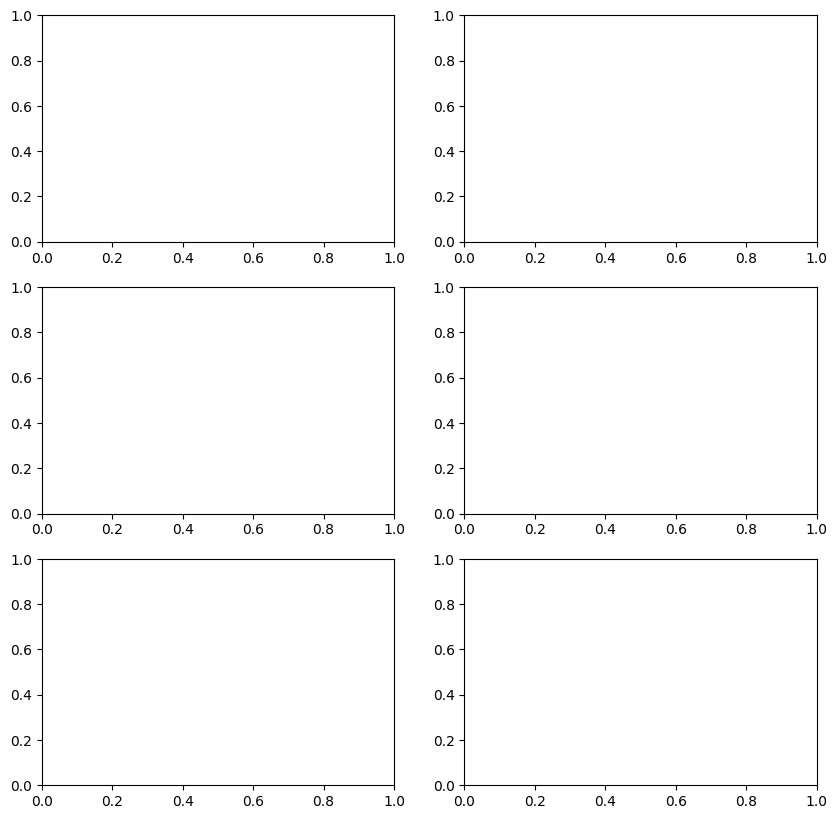

In [20]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))

for name, data in dataset_df.groupby('level_group'):
    axis[0, 0].plot(range(1, len(data['room_coor_x_std'])+1), data['room_coor_x_std'], label=name)
    axis[0, 1].plot(range(1, len(data['room_coor_y_std'])+1), data['room_coor_y_std'], label=name)
    axis[1, 0].plot(range(1, len(data['screen_coor_x_std'])+1), data['screen_coor_x_std'], label=name)
    axis[1, 1].plot(range(1, len(data['screen_coor_y_std'])+1), data['screen_coor_y_std'], label=name)
    axis[2, 0].plot(range(1, len(data['hover_duration'])+1), data['hover_duration_std'], label=name)
    axis[2, 1].plot(range(1, len(data['elapsed_time_std'])+1), data['elapsed_time_std'], label=name)
    

axis[0, 0].set_title('room_coor_x')
axis[0, 1].set_title('room_coor_y')
axis[1, 0].set_title('screen_coor_x')
axis[1, 1].set_title('screen_coor_y')
axis[2, 0].set_title('hover_duration')
axis[2, 1].set_title('elapsed_time_std')

for i in range(3):
    axis[i, 0].legend()
    axis[i, 1].legend()

plt.show()

Now let us split the dataset into training and testing datasets:

In [21]:
def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = dataset_df.index.unique()
    split = int(len(USER_LIST) * (1 - 0.20))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

train_x, valid_x = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_x), len(valid_x)))

56547 examples in training, 14139 examples in testing.


# Select a Model
There are several tree-based models for you to choose from.

- RandomForestModel
- GradientBoostedTreesModel
- CartModel
- DistributedGradientBoostedTreesModel

We can list all the available models in TensorFlow Decision Forests using the following code:

In [22]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

To get started, we'll work with a Gradient Boosted Trees Model. This is one of the well-known Decision Forest training algorithms.

A Gradient Boosted Decision Tree is a set of shallow decision trees trained sequentially. Each tree is trained to predict and then "correct" for the errors of the previously trained trees.

# How can I configure a tree-based model?

TensorFlow Decision Forests provides good defaults for you (e.g., the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:
```
rf = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
```

You can read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/GradientBoostedTreesModel).

# Training


We will train a model for each question to predict if the question will be answered correctly by a user. 
There are a total of 18 questions in the dataset. Hence, we will be training 18 models, one for each question.

We need to provide a few data structures to our training loop to store the trained models, predictions on the validation set and evaluation scores for the trained models.

We will create these using the following code:


In [118]:
# Fetch the unique list of user sessions in the validation dataset. We assigned 
# `session_id` as the index of our feature engineered dataset. Hence fetching 
# the unique values in the index column will give us a list of users in the 
# validation set.
VALID_USER_LIST = valid_x.index.unique()

# Create a dataframe for storing the predictions of each question for all users
# in the validation set.
# For this, the required size of the data frame is: 
# (no: of users in validation set  x no of questions).
# We will initialize all the predicted values in the data frame to zero.
# The dataframe's index column is the user `session_id`s. 
prediction_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)

# Create an empty dictionary to store the models created for each question.
models = {}

# Create an empty dictionary to store the evaluation score for each question.
evaluation_dict ={}

Before training the data we have to understand how `level_groups` and `questions` are associated to each other.

In this game the first quiz checkpoint(i.e., questions 1 to 3) comes after finishing levels 0 to 4. So for training questions 1 to 3 we will use data from the `level_group` 0-4. Similarly, we will use data from the `level_group` 5-12 to train questions from 4 to 13 and data from the `level_group` 13-22 to train questions from 14 to 18.

We will train a model for each question and store the trained model in the `models` dict.

In [112]:
def compute_class_weights(y_train):
    num_samples_class_0 = np.sum(y_train == 0)
    num_samples_class_1 = np.sum(y_train == 1)
    total_samples = y_train.shape[0]

    weight_for_class_0 = total_samples / (2 * num_samples_class_0)
    weight_for_class_1 = total_samples / (2 * num_samples_class_1)

    class_weights = np.where(y_train == 1, weight_for_class_1, weight_for_class_0)
    print(weight_for_class_0)
    print(weight_for_class_1)
    return class_weights



In [93]:

from tensorflow.keras.metrics import Precision, Recall

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [122]:
from collections import Counter
from imblearn.over_sampling import SMOTE

def apply_smote_if_imbalanced(X_train, y_train, imbalance_threshold=0.2):
    """
    Apply SMOTE to the training data if the dataset is imbalanced.

    Parameters:
    X_train (numpy array): Feature matrix of the training data.
    y_train (numpy array): Label vector of the training data.
    imbalance_threshold (float): Threshold for deciding if the dataset is imbalanced. Default is 0.1.

    Returns:
    X_train_resampled (numpy array): Resampled feature matrix of the training data.
    y_train_resampled (numpy array): Resampled label vector of the training data.
    """
    
    # Calculate class distribution
    class_counts = Counter(y_train)
    majority_count = max(class_counts.values())
    minority_count = min(class_counts.values())
    total_count = sum(class_counts.values())

    # Calculate the imbalance ratio
    imbalance_ratio = minority_count / majority_count

    # Apply SMOTE if the imbalance ratio is below the threshold
    if imbalance_ratio < imbalance_threshold:
        smote = SMOTE(sampling_strategy='minority', k_neighbors=5, random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        print('smote applied')
    else:
        X_train_resampled, y_train_resampled = X_train, y_train

    return X_train_resampled, y_train_resampled

In [123]:
# Iterate through questions 1 to 18 to train models for each question, evaluate
# the trained model and store the predicted values.
for q_no in range(1,19):

    # Select level group for the question based on the q_no.
    if q_no<=3: grp = '0-4'
    elif q_no<=13: grp = '5-12'
    elif q_no<=22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)
    
        
    # Filter the rows in the datasets based on the selected level group. 
    train_df = train_x.loc[train_x.level_group == grp]
    train_users = train_df.index.values
    valid_df = valid_x.loc[valid_x.level_group == grp]
    valid_users = valid_df.index.values    

# Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_users]
    valid_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_users]


    # Add the label to the filtered datasets.
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]

    X_train = train_df.iloc[:, 1:-1].values
    y_train = train_df.iloc[:, -1].values

    X_train_resampled, y_train_resampled = apply_smote_if_imbalanced(X_train, y_train, imbalance_threshold=0.2)

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_resampled, y_train_resampled))
    train_ds = train_dataset.batch(batch_size)

    batch_size = 1000
    X_val = valid_df.iloc[:, 1:-1].values
    y_val = valid_df.iloc[:, -1].values

    valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    valid_ds = valid_dataset.batch(batch_size)

    # We will now create the Gradient Boosted Trees Model with default settings. 
    # By default the model is set to train for a classification task.
    gbtm = tfdf.keras.GradientBoostedTreesModel(verbose=0)
    gbtm.compile(metrics=["accuracy", F1Score()])

    # Train the model.
    gbtm.fit(x=train_ds)

    


    # class_weights = compute_class_weights(y_train)
    # train_dataset_with_weights = tf.data.Dataset.from_tensor_slices((X_train, y_train, class_weights))
    # def map_features_labels_weights(x, y, w):
    #     return ({"input_features": x}, y, w)

    # train_ds_with_weights = train_dataset_with_weights.map(map_features_labels_weights)

    #  # Add the batch operation
    
    # train_ds_with_weights = train_ds_with_weights.batch(batch_size)

    # # Train the model
    # gbtm = tfdf.keras.GradientBoostedTreesModel(verbose=0)
    # gbtm.compile(metrics=["accuracy", F1Score()])
    # gbtm.fit(x=train_ds_with_weights)

    # Store the model
    models[f'{grp}_{q_no}'] = gbtm

    # Evaluate the trained model on the validation dataset and store the 
    # evaluation accuracy in the `evaluation_dict`.
    inspector = gbtm.make_inspector()
    inspector.evaluation()
    evaluation = gbtm.evaluate(x=valid_ds,return_dict=True)
    evaluation_dict[q_no] = {"accuracy": evaluation["accuracy"], "f1_score": evaluation["f1_score"]}      

    # Use the trained model to make predictions on the validation dataset and 
    # store the predicted values in the `prediction_df` dataframe.
    predict = gbtm.predict(x=valid_ds)
    prediction_df.loc[valid_users, q_no-1] = predict.flatten()      

### q_no 1 grp 0-4


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:38:49.9575 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:38:49.9575 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 3ms/step
### q_no 2 grp 0-4
smote applied


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:38:52.1830 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:38:52.1830 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 5ms/step
### q_no 3 grp 0-4
smote applied


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:39:01.0911 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:39:01.0911 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 5ms/step
### q_no 4 grp 5-12


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:39:11.6135 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:39:11.6135 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 3ms/step
### q_no 5 grp 5-12


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:39:12.1740 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:39:12.1740 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 3ms/step
### q_no 6 grp 5-12


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:39:17.2905 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:39:17.2905 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 3ms/step
### q_no 7 grp 5-12


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:39:19.0074 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:39:19.0074 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 3ms/step
### q_no 8 grp 5-12


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:39:20.1140 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:39:20.1140 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 3ms/step
### q_no 9 grp 5-12


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:39:20.6131 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:39:20.6131 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 3ms/step
### q_no 10 grp 5-12


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:39:21.1594 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:39:21.1594 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 3ms/step
### q_no 11 grp 5-12


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:39:21.7984 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:39:21.7984 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 3ms/step
### q_no 12 grp 5-12
smote applied


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:39:27.4668 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:39:27.4668 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 4ms/step
### q_no 13 grp 5-12


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:39:35.0043 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:39:35.0043 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 3ms/step
### q_no 14 grp 13-22


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:39:35.7992 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:39:35.7992 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 3ms/step
### q_no 15 grp 13-22


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:39:36.6844 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:39:36.6844 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 3ms/step
### q_no 16 grp 13-22


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:39:43.3151 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:39:43.3151 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 3ms/step
### q_no 17 grp 13-22


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:39:43.8044 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:39:43.8044 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 3ms/step
### q_no 18 grp 13-22
smote applied


/tmp/ipykernel_5588/1716278597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/1716278597.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 13:39:44.3503 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 13:39:44.3503 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 5ms/step


In [104]:
# Iterate through questions 1 to 18 to train models for each question, evaluate
# the trained model and store the predicted values.
for q_no in range(1,19):

    # Select level group for the question based on the q_no.
    if q_no<=3: grp = '0-4'
    elif q_no<=13: grp = '5-12'
    elif q_no<=22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)
    
        
    # Filter the rows in the datasets based on the selected level group. 
    train_df = train_x.loc[train_x.level_group == grp]
    train_users = train_df.index.values
    valid_df = valid_x.loc[valid_x.level_group == grp]
    valid_users = valid_df.index.values

    # Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_users]
    valid_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_users]

    # Add the label to the filtered datasets.
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]




    # There's one more step required before we can train the model. 
    # We need to convert the datatset from Pandas format (pd.DataFrame)
    # into TensorFlow Datasets format (tf.data.Dataset).
    # TensorFlow Datasets is a high performance data loading library 
    # which is helpful when training neural networks with accelerators like GPUs and TPUs.
    # We are omitting `level_group`, since it is not needed for training anymore.
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df.loc[:, train_df.columns != 'level_group'], label="correct")
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df.loc[:, valid_df.columns != 'level_group'], label="correct")



    # We will now create the Gradient Boosted Trees Model with default settings. 
    # By default the model is set to train for a classification task.
    gbtm = tfdf.keras.GradientBoostedTreesModel(verbose=0)
    gbtm.compile(metrics=["accuracy", F1Score()])

    # Train the model.
    gbtm.fit(x=train_ds)

    
    # Store the model
    models[f'{grp}_{q_no}'] = gbtm

    # Evaluate the trained model on the validation dataset and store the 
    # evaluation accuracy in the `evaluation_dict`.
    inspector = gbtm.make_inspector()
    inspector.evaluation()
    evaluation = gbtm.evaluate(x=valid_ds,return_dict=True)
    evaluation_dict[q_no] = {"accuracy": evaluation["accuracy"], "f1_score": evaluation["f1_score"]}          

    # Use the trained model to make predictions on the validation dataset and 
    # store the predicted values in the `prediction_df` dataframe.
    predict = gbtm.predict(x=valid_ds)
    prediction_df.loc[valid_users, q_no-1] = predict.flatten()     

### q_no 1 grp 0-4


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:02.3539 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:02.3539 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 12ms/step
### q_no 2 grp 0-4


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:04.8986 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:04.8987 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 11ms/step
### q_no 3 grp 0-4


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:06.6438 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:06.6438 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 11ms/step
### q_no 4 grp 5-12


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:08.5535 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:08.5535 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 11ms/step
### q_no 5 grp 5-12


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:10.6692 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:10.6692 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 11ms/step
### q_no 6 grp 5-12


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:13.4960 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:13.4960 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 12ms/step
### q_no 7 grp 5-12


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:15.6102 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:15.6102 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 11ms/step
### q_no 8 grp 5-12


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:16.5702 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:16.5702 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 11ms/step
### q_no 9 grp 5-12


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:17.5641 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:17.5641 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 11ms/step
### q_no 10 grp 5-12


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:21.3937 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:21.3937 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 11ms/step
### q_no 11 grp 5-12


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:22.0870 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:22.0871 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 11ms/step
### q_no 12 grp 5-12


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:22.6940 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:22.6941 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 11ms/step
### q_no 13 grp 5-12


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:23.2680 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:23.2680 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 11ms/step
### q_no 14 grp 13-22


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:30.6284 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:30.6284 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 11ms/step
### q_no 15 grp 13-22


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:32.1699 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:32.1699 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 11ms/step
### q_no 16 grp 13-22


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:33.0581 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:33.0581 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 11ms/step
### q_no 17 grp 13-22


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:33.6444 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:33.6444 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 11ms/step
### q_no 18 grp 13-22


/tmp/ipykernel_5588/3156198883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_5588/3156198883.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-04-21 12:50:39.6910 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-04-21 12:50:39.6910 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 12ms/step


In [105]:
evaluation_dict #base model

{1: {'accuracy': 0.7371101379394531, 'f1_score': 0.8438169360160828},
 2: {'accuracy': 0.9751750230789185, 'f1_score': 0.9874314069747925},
 3: {'accuracy': 0.9348610043525696, 'f1_score': 0.966304361820221},
 4: {'accuracy': 0.7956715226173401, 'f1_score': 0.8841572999954224},
 5: {'accuracy': 0.6390833854675293, 'f1_score': 0.70717853307724},
 6: {'accuracy': 0.7920644879341125, 'f1_score': 0.8813271522521973},
 7: {'accuracy': 0.7430511116981506, 'f1_score': 0.8504014015197754},
 8: {'accuracy': 0.6325058341026306, 'f1_score': 0.7668281197547913},
 9: {'accuracy': 0.7699978947639465, 'f1_score': 0.8658415079116821},
 10: {'accuracy': 0.609166145324707, 'f1_score': 0.6345238089561462},
 11: {'accuracy': 0.6615743637084961, 'f1_score': 0.7867361307144165},
 12: {'accuracy': 0.8690854907035828, 'f1_score': 0.9299261569976807},
 13: {'accuracy': 0.7239550352096558, 'f1_score': 0.17396822571754456},
 14: {'accuracy': 0.7383831739425659, 'f1_score': 0.842709481716156},
 15: {'accuracy': 0

In [95]:
evaluation_dict #class weights model

{1: {'accuracy': 0.6204116344451904, 'f1_score': 0.7044439911842346},
 2: {'accuracy': 0.7791215777397156, 'f1_score': 0.8742600679397583},
 3: {'accuracy': 0.6917037963867188, 'f1_score': 0.8104369640350342},
 4: {'accuracy': 0.6830044388771057, 'f1_score': 0.7777446508407593},
 5: {'accuracy': 0.6384468674659729, 'f1_score': 0.6804200410842896},
 6: {'accuracy': 0.679821789264679, 'f1_score': 0.7772035598754883},
 7: {'accuracy': 0.6479949355125427, 'f1_score': 0.74629145860672},
 8: {'accuracy': 0.5601527690887451, 'f1_score': 0.6120156645774841},
 9: {'accuracy': 0.6509653925895691, 'f1_score': 0.7464939951896667},
 10: {'accuracy': 0.611075758934021, 'f1_score': 0.6343506574630737},
 11: {'accuracy': 0.6303840279579163, 'f1_score': 0.7115893363952637},
 12: {'accuracy': 0.6535115838050842, 'f1_score': 0.7734146118164062},
 13: {'accuracy': 0.6329302191734314, 'f1_score': 0.4757574796676636},
 14: {'accuracy': 0.6479949355125427, 'f1_score': 0.7374584078788757},
 15: {'accuracy': 0

In [124]:
evaluation_dict #smote 

{1: {'accuracy': 0.7371101379394531, 'f1_score': 0.8438169360160828},
 2: {'accuracy': 0.9743263125419617, 'f1_score': 0.9869933724403381},
 3: {'accuracy': 0.9318904876708984, 'f1_score': 0.9647058248519897},
 4: {'accuracy': 0.7956715226173401, 'f1_score': 0.8841572999954224},
 5: {'accuracy': 0.6390833854675293, 'f1_score': 0.70717853307724},
 6: {'accuracy': 0.7922766804695129, 'f1_score': 0.8815199732780457},
 7: {'accuracy': 0.742838978767395, 'f1_score': 0.8502963781356812},
 8: {'accuracy': 0.6333545446395874, 'f1_score': 0.7703958749771118},
 9: {'accuracy': 0.766390860080719, 'f1_score': 0.864658772945404},
 10: {'accuracy': 0.6098026633262634, 'f1_score': 0.6360576748847961},
 11: {'accuracy': 0.6615743637084961, 'f1_score': 0.7867361307144165},
 12: {'accuracy': 0.8629323244094849, 'f1_score': 0.9261206984519958},
 13: {'accuracy': 0.7239550352096558, 'f1_score': 0.17396822571754456},
 14: {'accuracy': 0.7383831739425659, 'f1_score': 0.842709481716156},
 15: {'accuracy': 0.

# Inspect the Accuracy of the models.

We trained a model for each question. Now let us check the accuracy of each model and overall accuracy for all the models combined. 

Note: Since the label distribution is imbalanced, we can't make an assumption on the model performance from accuracy score alone. 

In [106]:
for name, value in evaluation_dict.items():
  print(f"question {name}: accuracy {value:.4f}")

print("\nAverage accuracy", sum(evaluation_dict.values())/18)

TypeError: unsupported format string passed to dict.__format__

# Visualize the model

One benefit of tree-based models is that we can easily visualize them. The default number of trees used in the Random Forests is 300. 

Let us pick one model from `models` dict and select a tree to display below.

In [77]:
tfdf.model_plotter.plot_model_in_colab(models['0-4_1'], tree_idx=0, max_depth=3)

# Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests. Let us pick one model from models dict and inspect it.

Let us list the available Variable Importances for Decision Trees:

In [107]:
inspector = models['0-4_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


As an example, let us display the important features for the Variable Importance NUM_AS_ROOT.

The larger the importance score for NUM_AS_ROOT, the more impact it has on the outcome of the model for Question 1(i.e., model\["0-4_1"\]).

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the gradient boosted trees  than any other feature.

In [108]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("object_click_sum" (1; #27), 17.0),
 ("name_nunique" (1; #18), 6.0),
 ("person_click_sum" (1; #33), 5.0),
 ("notification_click" (1; #22), 4.0),
 ("notification_click_std" (1; #23), 4.0),
 ("navigate_click" (1; #19), 3.0),
 ("navigate_click_std" (1; #20), 3.0),
 ("cutscene_click_std" (1; #5), 2.0),
 ("observation_click" (1; #28), 2.0),
 ("person_click_std" (1; #32), 2.0),
 ("room_fqid_nunique" (1; #34), 2.0),
 ("cutscene_click_sum" (1; #6), 1.0),
 ("elapsed_time" (1; #7), 1.0),
 ("elapsed_time_std" (1; #8), 1.0),
 ("map_click" (1; #12), 1.0)]

# Threshold-Moving for Imbalanced Classification

Since the values of the column `correct` is fairly imbalanced, using the default threshold of `0.5` to map the predictions into classes 0 or 1 can result in poor performance. 
In such cases, to improve performance we will calculate the `F1 score` for a certain range of thresholds and try to find the best threshold aka, threshold with highest `F1 score`. Then we will use this threshold to map the predicted probabilities to class labels 0 or 1.

Please note that we are using `F1 score` since it is a better metric than `accuracy` to evaluate problems with class imbalance.

In [125]:
# Create a dataframe of required size:
# (no: of users in validation set x no: of questions) initialized to zero values
# to store true values of the label `correct`. 
true_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)
for i in range(18):
    # Get the true labels.
    tmp = labels.loc[labels.q == i+1].set_index('session').loc[VALID_USER_LIST]
    true_df[i] = tmp.correct.values

max_score = 0; best_threshold = 0

# Loop through threshold values from 0.4 to 0.8 and select the threshold with 
# the highest `F1 score`.
for threshold in np.arange(0.4,0.8,0.01):
    metric = tfa.metrics.F1Score(num_classes=2,average="macro",threshold=threshold)
    y_true = tf.one_hot(true_df.values.reshape((-1)), depth=2)
    y_pred = tf.one_hot((prediction_df.values.reshape((-1))>threshold).astype('int'), depth=2)
    metric.update_state(y_true, y_pred)
    f1_score = metric.result().numpy()
    if f1_score > max_score:
        max_score = f1_score
        best_threshold = threshold
        
print("Best threshold ", best_threshold, "\tF1 score ", max_score)

Best threshold  0.6300000000000002 	F1 score  0.6761711


# Submission

Here you'll use the `best_threshold` calculate in the previous cell

In [26]:
# Reference
# https://www.kaggle.com/code/philculliton/basic-submission-demo
# https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook


import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (test, sample_submission) in iter_test:
    test_df = feature_engineer(test)
    grp = test_df.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        gbtm = models[f'{grp}_{t}']
        test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df.loc[:, test_df.columns != 'level_group'])
        predictions = gbtm.predict(test_ds)
        mask = sample_submission.session_id.str.contains(f'q{t}')
        n_predictions = (predictions > best_threshold).astype(int)
        sample_submission.loc[mask,'correct'] = n_predictions.flatten()
    
    env.predict(sample_submission)

ModuleNotFoundError: No module named 'jo_wilder'

In [ ]:
! head submission.csv